In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
# For parallelization
from joblib import Parallel, delayed

import matplotlib.patches as mpatches

import lmfit
import nekhoroshev_tools as nt

### Gathering B1 data to fit...

In [2]:
I_min = 0.0

In [3]:
with open("b1_160.pkl", 'rb') as f:
    t_160, loss_160, intensity_160 = pickle.load(f)

with open("b1_150.pkl", 'rb') as f:
    t_150, loss_150, intensity_150 = pickle.load(f)

with open("b1_140.pkl", 'rb') as f:
    t_140, loss_140, intensity_140 = pickle.load(f)

with open("b1_130.pkl", 'rb') as f:
    t_130, loss_130, intensity_130 = pickle.load(f)

In [4]:
norm_loss_160 = np.empty_like(loss_160)

for i in range(len(loss_160)):
    norm_loss_160[i] = 1 - scipy.integrate.trapz(loss_160[:i]/intensity_160, t_160[:i])

norm_loss_150 = np.empty_like(loss_150)

for i in range(len(loss_150)):
    norm_loss_150[i] = norm_loss_160[-1] - scipy.integrate.trapz(loss_150[:i]/intensity_160, t_150[:i])

norm_loss_140 = np.empty_like(loss_140)

for i in range(len(loss_140)):
    norm_loss_140[i] = norm_loss_150[-1] - scipy.integrate.trapz(loss_140[:i]/intensity_160, t_140[:i])

norm_loss_130 = np.empty_like(loss_130)

for i in range(len(loss_130)):
    norm_loss_130[i] = norm_loss_140[-1] - scipy.integrate.trapz(loss_130[:i]/intensity_160, t_130[:i])

t_ratio_160 = t_160[-1] / t_160[-1]
t_ratio_150 = (t_150[-1] - t_150[0]) / t_160[-1]
t_ratio_140 = (t_140[-1] - t_140[0]) / t_160[-1]
t_ratio_130 = (t_130[-1] - t_130[0]) / t_160[-1]

In [85]:
t_160

array([0.00000000e+00, 1.09076500e+04, 1.51582600e+04, ...,
       2.36518334e+07, 2.36591764e+07, 2.36703877e+07])

In [89]:
norm_loss_b1_all = np.concatenate((norm_loss_160, norm_loss_150, norm_loss_140, norm_loss_130))

delta_t = t_160[-1] - t_160[-2]
print(delta_t)

t_b1_all = np.concatenate((t_160, t_150+t_160[-1]+delta_t, t_140+t_160[-1]+t_150[-1]+delta_t*2, t_130+t_160[-1]+t_150[-1]+t_140[-1]+delta_t*3))

11211.265000000596


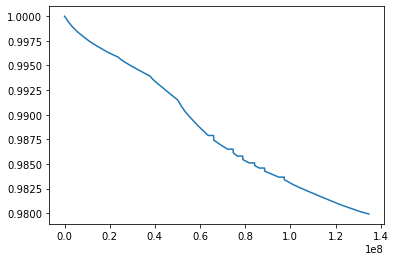

In [91]:
plt.plot(t_b1_all, norm_loss_b1_all)

In [92]:
b1_full_interp = scipy.interpolate.interp1d(t_b1_all, norm_loss_b1_all, kind="cubic")

In [8]:
t_150[-1] / t_160[-1]

1.5417123424932906

In [9]:
t_140

array([42237648.12624501, 42248915.605     , 42252918.836245  , ...,
       54348636.81      , 54359780.605     , 54371261.761245  ])

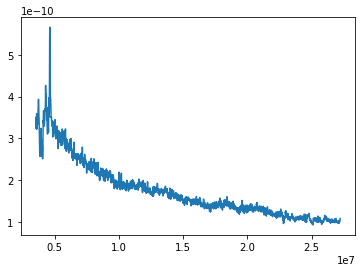

In [10]:
plt.plot(t_160, loss_160/intensity_160, label='160')

In [11]:
normalized_loss = np.empty_like(loss_160)

for i in tqdm(range(len(loss_160))):
    normalized_loss[i] = 1 - scipy.integrate.trapz(loss_160[:i]/intensity_160, t_160[:i])

  0%|          | 0/2320 [00:00<?, ?it/s]

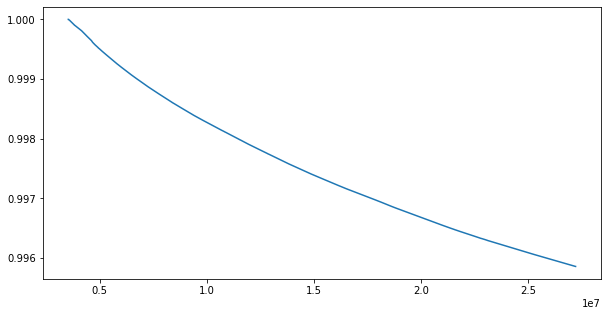

In [12]:
plt.figure(figsize=(10,5))
plt.plot(t_160, normalized_loss, label='160')

In [13]:
x = t_160 - t_160[0]
y = loss_160/intensity_160

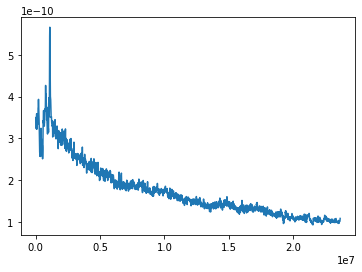

In [14]:
plt.plot(x, y)

In [15]:
all_t = np.concatenate((t_160, t_150, t_140, t_130))
all_loss = np.concatenate((loss_160, loss_150, loss_140, loss_130))/intensity_160

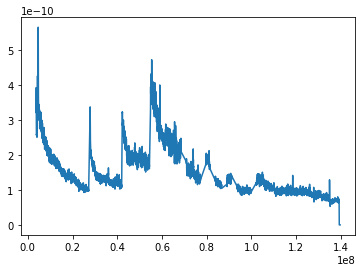

In [16]:
plt.plot(all_t, all_loss)

In [17]:
all_normalized_intensity = np.empty_like(all_loss)

for i in range(len(all_loss)):
    all_normalized_intensity[i] = 1 - scipy.integrate.trapz(all_loss[:i], all_t[:i])

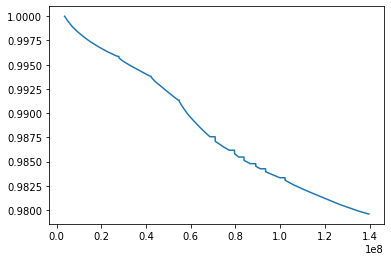

In [18]:
plt.plot(all_t, all_normalized_intensity)

In [19]:
def resid_test(p, x, y):
    k = p["k"].value
    p["test"].value = 2.5
    model = np.exp(-k * x)
    return (y - model)

x = np.linspace(1, 10, 1000)
y = np.exp(-3 * x)

params = lmfit.Parameters()
params.add("k", value=1.0)
params.add("test", value=-1.0)

result = lmfit.minimize(resid_test, params, args=(x, y))
result

In [20]:
def full_iteration(I_star, k, I_max, I0, dt, n_steps=10000):
    engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)

    vals = []
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    data_0 = engine.get_data_with_x()

    for i in range(n_steps):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
    
    data_1 = engine.get_data_with_x()

    return vals, data_0, data_1, engine

In [21]:
def compute_loss(engine: cn.cn_generic, starting_point: float, iterations=10000):
    vals = []
    rel_vals = [starting_point]
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    real_val = vals[0] / starting_point

    data_0 = engine.get_data_with_x()

    for i in range(iterations):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
        rel_vals.append(vals[-1]/(real_val))
    
    data_1 = engine.get_data_with_x()

    return vals, rel_vals, data_0, data_1

In [22]:
def iterate_to_loss(engine: cn.cn_generic, starting_point: float, ending_point: float, maximum_iterations=100000):
    vals = []
    rel_vals = [starting_point]
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    real_val = vals[0] / starting_point

    reached = False

    for i in range(maximum_iterations):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
        rel_vals.append(vals[-1]/(real_val))
        if rel_vals[-1] < ending_point:
            reached = True
            break

    if not reached:
        print("Reached maximum iterations")
        return reached, vals, rel_vals, i
    else:
        # print("Reached after {} iterations".format(i))
        return reached, vals, rel_vals, i

In [127]:
samples = 3000
def test_parameters(I_star: float, k: float, I_max: float, starting_point: float, ending_point: float, I0=None):
    I_min = 0.0
    dt = 1.0
    if I0 is None:
        I0 = np.exp(-np.linspace(I_min, I_max, samples))
    while True:
        # print("dt: {}".format(dt))
        engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
        reached, vals, rel_vals, i = iterate_to_loss(engine, starting_point, ending_point)
        if reached:
            break
        else:
            # print("I_star: {}, k: {}".format(I_star, k))
            # dt *= 1000
            print("Just keeping it for speed...")
            break
    
    new_dt = i * dt / 10000
    if new_dt <= 0.0:
        print("What the heck???")
        new_dt = dt / 10000
    engine = cn.cn_generic(I_min, I_max, I0, new_dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
    vals, rel_vals, data_0, data_1 = compute_loss(engine, starting_point)
    return vals, rel_vals, new_dt
    

In [24]:
def align_time(t_data: np.ndarray, l_data: np.ndarray, t_model: np.ndarray, l_model: np.ndarray):
    t_data -= t_data[0]
    t_final = t_data[-1]
    scale_factor = t_final / t_model[-1]
    t_model *= scale_factor
    f_interp = scipy.interpolate.interp1d(t_model, l_model, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return t_data, l_data, f_interp(t_data), scale_factor

In [25]:
def resid_lmfit(params, t_data, l_data, I0=None):
    I_star = params['I_star'].value
    k = params['k'].value
    I_max = params['I_max'].value
    starting_point = params['starting_point'].value
    ending_point = params['ending_point'].value

    # print("I_star: {}".format(I_star), "k: {}".format(k))
    
    vals, rel_vals, new_dt = test_parameters(I_star, k, I_max, starting_point, ending_point, I0)
    t_data, l_data, l_model, scale_factor = align_time(t_data, l_data, np.arange(len(rel_vals))*new_dt, rel_vals)

    params['dt'].value = new_dt
    params['scale_factor'].value = scale_factor
    params['n_iterations'].value = 10000

    return l_data - l_model


def resid_fixed_dt(params, t_data, l_data, I0=None):
    I_star = params['I_star'].value
    k = params['k'].value
    I_max = params['I_max'].value
    starting_point = params['starting_point'].value
    ending_point = params['ending_point'].value
    dt = params['dt'].value
    n_iterations = params['n_iterations'].value
    scale_factor = params['scale_factor'].value
    I_min = 0.0
    
    # print("I_star: {}".format(I_star))
    # print("k: {}".format(k))
    
    engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
    vals, rel_vals, data_0, data_1 = compute_loss(engine, starting_point, n_iterations)
    times = np.arange(len(rel_vals)) * dt * scale_factor
    interp_func = scipy.interpolate.interp1d(times, rel_vals, kind='cubic')
    
    return l_data - interp_func(t_data)

## Brute force variant

In [30]:
samples = 3000
I_max = 7.1

In [31]:
workers = os.cpu_count()
Ns = 10

min_I_star = 20.0
max_I_star = 150.0

_, d_I_star = np.linspace(min_I_star, max_I_star, Ns, retstep=True)

min_k = 0.3
max_k = 1.2

_, d_k = np.linspace(min_k, max_k, Ns, retstep=True)

In [32]:
def zerofy_near_border(I0: np.ndarray, border_width: int = 10) -> np.ndarray:
    """
    Zerofy the values near the border the array following a linear law.
    """
    coeff = np.linspace(1, 0, border_width)
    I0[-border_width:] = coeff * I0[-border_width:]
    return I0

I_160 = np.exp(-np.linspace(I_min, I_max, samples))
I_160 = zerofy_near_border(I_160, 100)


In [33]:
print("ANGLE: 160")

params = lmfit.Parameters()
params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
params.add('k', value=0.9, min=min_k, max=max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_160[0], vary=False)
params.add('ending_point', value=norm_loss_160[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_160 = lmfit.minimize(resid_lmfit, params, args=(t_160, norm_loss_160, I_160), method="brute", workers=workers, Ns=Ns)

print("Brute result:")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

print("Refining:")
new_min_I_star = result_160.params['I_star'].value - d_I_star
new_max_I_star = result_160.params['I_star'].value + d_I_star
new_min_k = result_160.params['k'].value - d_k
new_max_k = result_160.params['k'].value + d_k

params = lmfit.Parameters()
params.add('I_star', value=result_160.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
params.add('k', value=result_160.params['k'].value, min=new_min_k, max=new_max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_160[0], vary=False)
params.add('ending_point', value=norm_loss_160[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_160 = lmfit.minimize(resid_lmfit, params, args=(t_160, norm_loss_160, I_160))

print("Refined result:")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

ANGLE: 160


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halve

Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


Brute result:
I_star: 92.22222222222223
k: 0.7
scale_factor: 2958798.4562500003
Refining:
Refined result:
I_star: 90.20361704261727
k: 0.6963094174504874
scale_factor: 2958798.4562500003


In [34]:
vals, data0, data1, _ = full_iteration(
    result_160.params['I_star'].value,
    result_160.params['k'].value,
    result_160.params['I_max'].value,
    I_160,
    result_160.params['dt'].value,
    n_steps=10000)

I_150 = data1[1]

In [35]:
print("ANGLE: 150")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
params.add('k', value=0.9, min=min_k, max=max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_150[0], vary=False)
params.add('ending_point', value=norm_loss_150[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_150 = lmfit.minimize(resid_lmfit, params, args=(t_150, norm_loss_150, I_150), method="brute", workers=workers, Ns=Ns)

print("Brute result:")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

print("Refining:")
new_min_I_star = result_150.params['I_star'].value - d_I_star
new_max_I_star = result_150.params['I_star'].value + d_I_star
new_min_k = result_150.params['k'].value - d_k
new_max_k = result_150.params['k'].value + d_k

params = lmfit.Parameters()
params.add('I_star', value=result_150.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
params.add('k', value=result_150.params['k'].value, min=new_min_k, max=new_max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_150[0], vary=False)
params.add('ending_point', value=norm_loss_150[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_150 = lmfit.minimize(resid_lmfit, params, args=(t_150, norm_loss_150, I_150))

print("Refined result:")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

ANGLE: 150
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Brute result:
I_star: 121.11111111111111
k: 0.7
scale_factor: 1764081.8635943746
Refining:
Refined result:
I_star: 123.23921550054665
k: 0.6982529452007699
scale_factor: 1764081.8635943746


In [36]:
vals, data0, data1, _ = full_iteration(
    result_150.params['I_star'].value,
    result_150.params['k'].value,
    result_150.params['I_max'].value,
    I_150,
    result_150.params['dt'].value,
    n_steps=10000)

I_140 = data1[1]

In [37]:
print("ANGLE: 140")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
params.add('k', value=0.9, min=min_k, max=max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_140[0], vary=False)
params.add('ending_point', value=norm_loss_140[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_140 = lmfit.minimize(resid_lmfit, params, args=(t_140, norm_loss_140, I_140), method="brute", workers=workers, Ns=Ns)

print("Brute result:")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)

print("Refining:")
new_min_I_star = result_140.params['I_star'].value - d_I_star
new_max_I_star = result_140.params['I_star'].value + d_I_star
new_min_k = result_140.params['k'].value - d_k
new_max_k = result_140.params['k'].value + d_k

params = lmfit.Parameters()
params.add('I_star', value=result_140.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
params.add('k', value=result_140.params['k'].value, min=new_min_k, max=new_max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_140[0], vary=False)
params.add('ending_point', value=norm_loss_140[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_140 = lmfit.minimize(resid_lmfit, params, args=(t_140, norm_loss_140, I_140))

print("Refined result:")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)


ANGLE: 140
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Brute result:
I_star: 121.11111111111111
k: 0.7
scale_factor: 713741.9785294113
Refining:
Refined result:
I_star: 135.4679423521491
k: 0.6810307509325658
scale_factor: 713741.9785294113


In [38]:
vals, data0, data1, _ = full_iteration(
    result_140.params['I_star'].value,
    result_140.params['k'].value,
    result_140.params['I_max'].value,
    I_140,
    result_140.params['dt'].value,
    n_steps=10000)

I_130 = data1[1]

In [39]:
print("ANGLE: 130")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
params.add('k', value=0.9, min=min_k, max=max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_130[0], vary=False)
params.add('ending_point', value=norm_loss_130[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_130 = lmfit.minimize(resid_lmfit, params, args=(t_130, norm_loss_130, I_130), method="brute", workers=workers, Ns=Ns)

print("Brute result:")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

print("Refining:")
new_min_I_star = result_130.params['I_star'].value - d_I_star
new_max_I_star = result_130.params['I_star'].value + d_I_star
new_min_k = result_130.params['k'].value - d_k
new_max_k = result_130.params['k'].value + d_k

params = lmfit.Parameters()
params.add('I_star', value=result_130.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
params.add('k', value=result_130.params['k'].value, min=new_min_k, max=new_max_k)
params.add('I_max', value=I_max, vary=False)
params.add('starting_point', value=norm_loss_130[0], vary=False)
params.add('ending_point', value=norm_loss_130[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_130 = lmfit.minimize(resid_lmfit, params, args=(t_130, norm_loss_130, I_130))

print("Refined result:")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

ANGLE: 130
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keepi

In [40]:
print("ANGLE: 160")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

print("ANGLE: 150")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

print("ANGLE: 140")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)

print("ANGLE: 130")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

ANGLE: 160
I_star: 90.20361704261727
k: 0.6963094174504874
scale_factor: 2958798.4562500003
ANGLE: 150
I_star: 123.23921550054665
k: 0.6982529452007699
scale_factor: 1764081.8635943746
ANGLE: 140
I_star: 135.4679423521491
k: 0.6810307509325658
scale_factor: 713741.9785294113
ANGLE: 130
I_star: 63.33358583071508
k: 0.8000016793899924
scale_factor: 377041.50153886667


In [45]:
with open("fit_results_b1.pkl", 'wb') as f:
    pickle.dump([result_160, result_150, result_140, result_130], f)

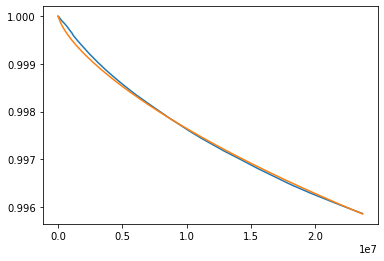

In [41]:
plt.plot(t_160, norm_loss_160)
plt.plot(t_160, norm_loss_160 - result_160.residual)


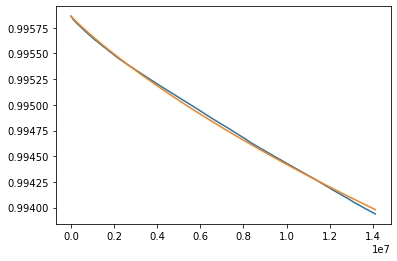

In [42]:
plt.plot(t_150, norm_loss_150)
plt.plot(t_150, norm_loss_150 - result_150.residual)


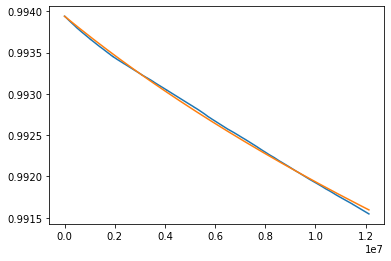

In [43]:
plt.plot(t_140, norm_loss_140)
plt.plot(t_140, norm_loss_140 - result_140.residual)


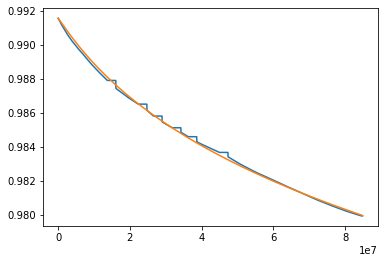

In [44]:
plt.plot(t_130, norm_loss_130)
plt.plot(t_130, norm_loss_130 - result_130.residual)


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


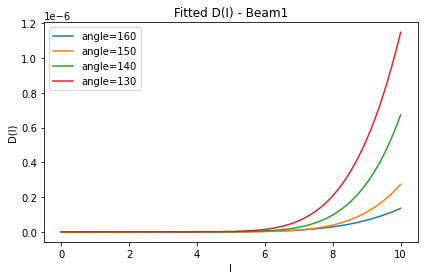

In [46]:
plt.figure()

I_test = np.linspace(0, 10, 1000)
    
for l, f in zip(["160", "150", "140", "130"], [result_160, result_150, result_140, result_130]):
    plt.plot(
        I_test,
        nt.D(I_test, f.params['I_star'].value, f.params['k'].value, nt.standard_c(0.0, 10, f.params['I_star'].value, f.params['k'].value), True) / f.params['scale_factor'].value,
        label=f"angle={l}")

plt.legend()
plt.xlabel("I")
plt.ylabel("D(I)")

plt.title("Fitted D(I) - Beam1")
plt.tight_layout()

plt.savefig("img/fokker_planck_b1_D.png", dpi=300)


### Gathering B2 data to fit...

In [47]:
TURNS_PER_SECOND = 11245.0

In [48]:
from dataclasses import dataclass

@dataclass
class LossSample:
    loss: np.ndarray
    loss_t: np.ndarray
    loss_timestamp: np.ndarray

    intensity: np.ndarray
    intensity_t: np.ndarray
    intensity_timestamp: np.ndarray

    angle: float
    wire: bool
    octupole: bool

In [49]:
with open("loss_list_b2.pkl", "rb") as f:
    loss_list_b2 = pickle.load(f)

with open("loss_list_cont_b2.pkl", "rb") as f:
    loss_list_cont_b2 = pickle.load(f)

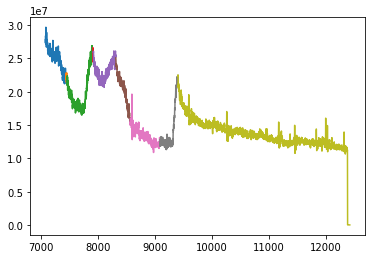

In [50]:
for b in loss_list_cont_b2[17:]:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

In [51]:
intensity_0 = loss_list_cont_b2[0].intensity[0]
data_block = []
beam_now = 1.0

for b in loss_list_cont_b2:
    turns = (b.loss_t) * TURNS_PER_SECOND
    turns_0 = (b.loss_t - b.loss_t[0]) * TURNS_PER_SECOND
    loss = b.loss / TURNS_PER_SECOND

    relative_loss = []

    for i in range(len(loss)):
        relative_loss.append(
            beam_now - scipy.integrate.trapz(loss[:i], turns[:i]) / intensity_0
        )
    
    data_block.append((turns_0, relative_loss, turns, loss))
    beam_now = relative_loss[-1]

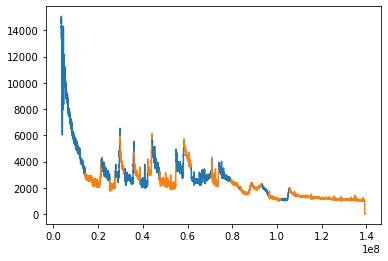

In [52]:
for i, d in enumerate(data_block):
    plt.plot(d[2], d[3], c=["C0", "C1"][i % 2])

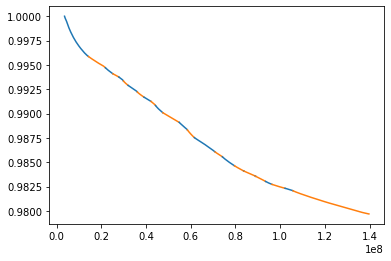

In [53]:
t = np.array([])
l = np.array([])
for i, d in enumerate(data_block):
    plt.plot(d[2], d[1], c=["C0", "C1"][i % 2])
    t = np.append(t, d[2])
    l = np.append(l, d[1])

final_loss_full = d[1][-1]
full_loss_f = scipy.interpolate.interp1d(t, l, kind="previous")

In [54]:
intensity_0 = loss_list_b2[0].intensity[0]
data_block = []
beam_now = 1.0

for b in loss_list_b2:
    turns = (b.loss_t) * TURNS_PER_SECOND
    turns_0 = (b.loss_t - b.loss_t[0]) * TURNS_PER_SECOND
    loss = b.loss / TURNS_PER_SECOND

    relative_loss = []

    for i in range(len(loss)):
        relative_loss.append(
            beam_now - scipy.integrate.trapz(loss[:i], turns[:i]) / intensity_0
        )
    
    data_block.append((turns_0, relative_loss, turns, loss))
    beam_now = relative_loss[-1]

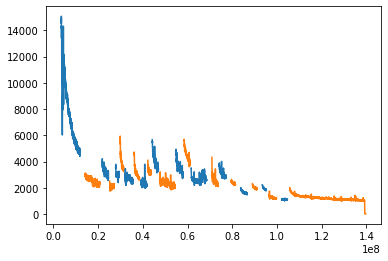

In [55]:
for i, d in enumerate(data_block):
    plt.plot(d[2], d[3], c=["C0", "C1"][i % 2])

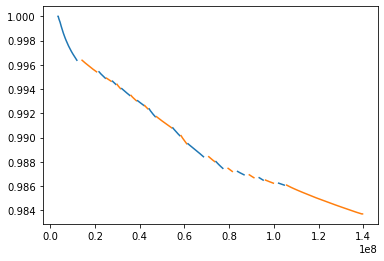

In [56]:
t = np.array([])
l = np.array([])
for i, d in enumerate(data_block):
    plt.plot(d[2], d[1], c=["C0", "C1"][i % 2])
    t = np.append(t, d[2])
    l = np.append(l, d[1])
    
final_loss_partial = d[1][-1]
partial_loss_f = scipy.interpolate.interp1d(t, l, kind="previous")

In [57]:
timestapms_for_b1 = []

for i, d in enumerate(data_block):
    timestapms_for_b1.append([d[2][0], d[2][-1]])

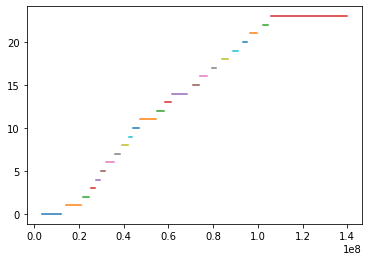

In [58]:
for i, t in enumerate(timestapms_for_b1):
    plt.plot(t, [i, i])

In [65]:
absolute_loss_list = []
relative_loss_list = []

for i in range(len(data_block)):
    start_loss = full_loss_f(data_block[i][2][0])
    partial_loss = full_loss_f(data_block[i][2][-1])
    if i < len(data_block) - 1:
        full_loss = full_loss_f(data_block[i+1][2][0])
    else:
        full_loss = partial_loss

    absolute_loss_list.append(partial_loss - full_loss)
    relative_loss_list.append((partial_loss - full_loss) / (start_loss - full_loss))

    print("start_loss", start_loss)
    print("partial_loss", partial_loss)
    print("full_loss", full_loss)
    print("absolute_loss", partial_loss - full_loss)
    print("relative_loss", (partial_loss - full_loss) / (start_loss - full_loss))
    print("")

start_loss 1.0
partial_loss 0.9963741312738975
full_loss 0.9958632309293568
absolute_loss 0.0005109003445407101
relative_loss 0.12350226367875876

start_loss 0.9958632309293568
partial_loss 0.9949111737515106
full_loss 0.9947049611967
absolute_loss 0.00020621255481056977
relative_loss 0.1780350025529665

start_loss 0.9947049611967
partial_loss 0.994176719104501
full_loss 0.9940873332146517
absolute_loss 8.938588984930274e-05
relative_loss 0.1447244821273441

start_loss 0.9940873332146517
partial_loss 0.9938412661671407
full_loss 0.9937559339625831
absolute_loss 8.533220455764212e-05
relative_loss 0.2574906371242465

start_loss 0.9937559339625831
partial_loss 0.9934981439110122
full_loss 0.9933508302100136
absolute_loss 0.00014731370099863028
relative_loss 0.36364437521063964

start_loss 0.9933508302100136
partial_loss 0.9929979206563063
full_loss 0.9928970131499189
absolute_loss 0.00010090750638747092
relative_loss 0.22235282729654862

start_loss 0.9928970131499189
partial_loss 0.99233

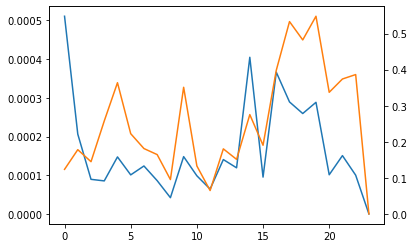

In [69]:
plt.plot(absolute_loss_list)
plt.twinx()
plt.plot(relative_loss_list, c="C1")

In [112]:
samples = 3000
I_max = 7.1

In [113]:
workers = os.cpu_count()
Ns = 10

min_I_star = 20.0
max_I_star = 150.0

_, d_I_star = np.linspace(min_I_star, max_I_star, Ns, retstep=True)

min_k = 0.3
max_k = 1.2

_, d_k = np.linspace(min_k, max_k, Ns, retstep=True)

In [114]:
def zerofy_near_border(I0: np.ndarray, border_width: int = 10) -> np.ndarray:
    """
    Zerofy the values near the border the array following a linear law.
    """
    coeff = np.linspace(1, 0, border_width)
    I0[-border_width:] = coeff * I0[-border_width:]
    return I0

I_0 = np.exp(-np.linspace(I_min, I_max, samples))
I_0 = zerofy_near_border(I_0, 100)

In [115]:
fit_results = []
I_list = [I_0]

for i, d in tqdm(enumerate(data_block), total=len(data_block)):
    print("i:", i)
    print(d[1][0], d[1][-1])
    
    params = lmfit.Parameters()
    params.add('I_max', value=I_max, vary=False)
    params.add('starting_point', value=d[1][0], vary=False)
    params.add('ending_point', value=d[1][-1], vary=False)
    params.add('dt', value=-1, vary=False)
    params.add('scale_factor', value=-1, vary=False)
    params.add('n_iterations', value=-1, vary=False)
    params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
    params.add('k', value=0.9, min=min_k, max=max_k)
    
    result = lmfit.minimize(resid_lmfit, params, args=(d[0], d[1], I_0), method="brute", workers=20, Ns=20)
    
    print("Brute result:")
    print("I_star:", result.params['I_star'].value)
    print("k:", result.params['k'].value)
    print("scale_factor:", result.params['scale_factor'].value)

    print("Refining:")
    new_min_I_star = result.params['I_star'].value - d_I_star
    new_max_I_star = result.params['I_star'].value + d_I_star
    new_min_k = result.params['k'].value - d_k
    new_max_k = result.params['k'].value + d_k

    params = lmfit.Parameters()
    params.add('I_max', value=I_max, vary=False)
    params.add('starting_point', value=d[1][0], vary=False)
    params.add('ending_point', value=d[1][-1], vary=False)
    params.add('dt', value=-1, vary=False)
    params.add('scale_factor', value=-1, vary=False)
    params.add('n_iterations', value=-1, vary=False)
    params.add('I_star', value=result.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
    params.add('k', value=result.params['k'].value, min=new_min_k, max=new_max_k)

    result = lmfit.minimize(resid_lmfit, params, args=(d[0], d[1], I_0))
    fit_results.append(result)

    print("Refined result:")
    print("I_star:", result.params['I_star'].value)
    print("k:", result.params['k'].value)
    print("scale_factor:", result.params['scale_factor'].value)

    vals, data0, data1, _ = full_iteration(
        result.params['I_star'].value,
        result.params['k'].value,
        result.params['I_max'].value,
        I_0,
        result.params['dt'].value,
        n_steps=10000)

    I_0 = data1[1]
    I_list.append(I_0)

  0%|          | 0/24 [00:00<?, ?it/s]

i: 0
1.0 0.9963741312738975


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halve

Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for s

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


Brute result:
I_star: 20.0
k: 1.0578947368421052
scale_factor: 1394333.1477075003
Refining:
Refined result:
I_star: 19.849207932836464
k: 1.0548366454409304
scale_factor: 1394333.1477075003
i: 1
0.9963741312738975 0.9954220740960513
Reached maximum iterations
Just keeping it for speed...
Reached maximum iterations
Just keeping it for speed...
Brute result:
I_star: 150.0
k: 0.7736842105263158
scale_factor: 2162735.860415001
Refining:
Refined result:
I_star: 156.47559095601196
k: 0.7693728047324117
scale_factor: 2162735.860415001
i: 2
0.9954220740960513 0.9948938320038523


KeyboardInterrupt: 

In [ ]:
with open("fit_results_b2.pkl", "wb") as f:
    pickle.dump((fit_results, I_list), f)

In [ ]:
with open("fit_results_b2.pkl", "rb") as f:
    fit_results, I_list = pickle.load(f)

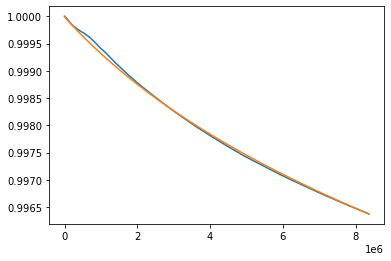

In [105]:
idx = 0
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

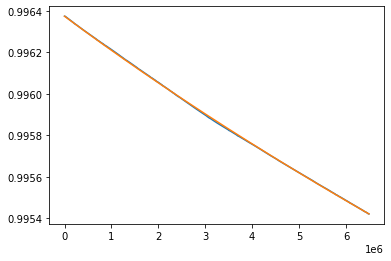

In [106]:
idx = 1
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

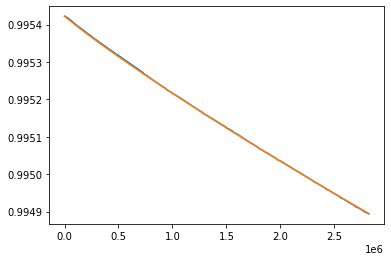

In [107]:
idx = 2
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

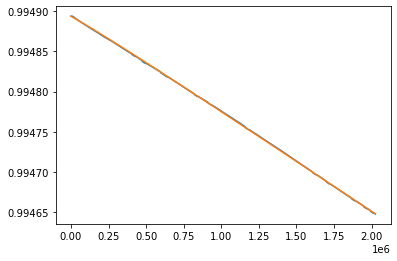

In [108]:
idx = 3
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

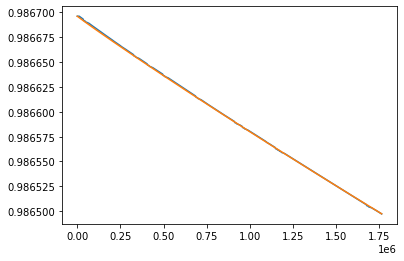

In [109]:
idx = -4
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

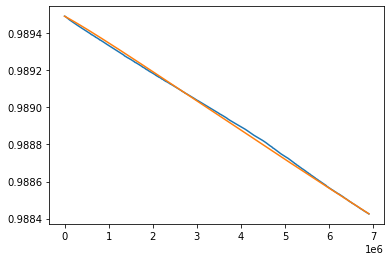

In [110]:
idx = -10
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

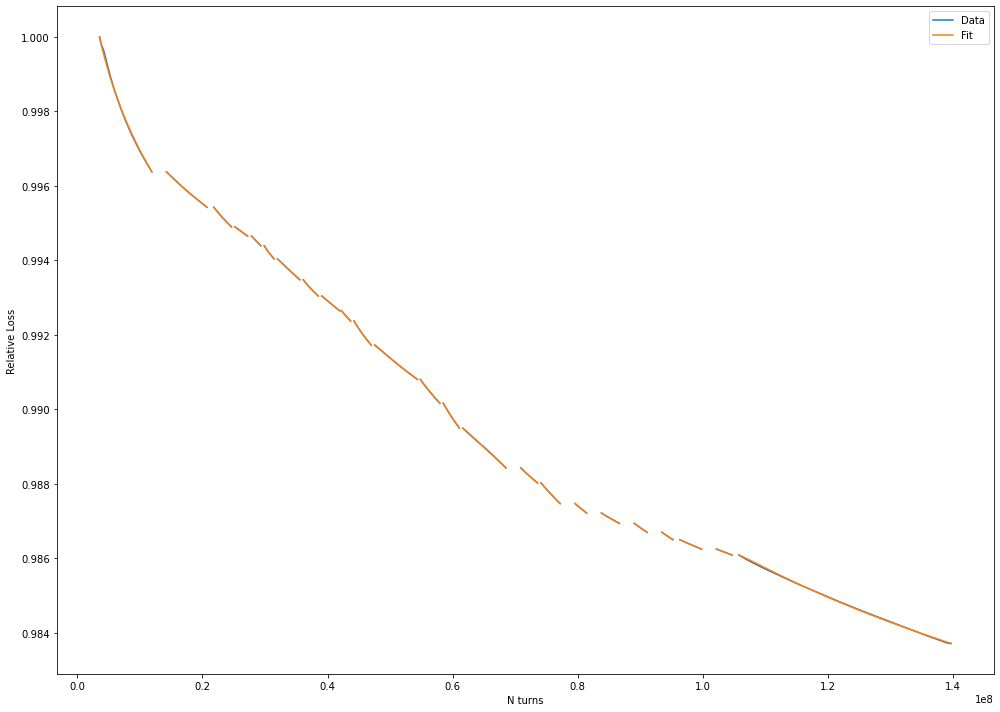

In [183]:
plt.figure(figsize=(14, 10))
for i, d in enumerate(data_block):
    plt.plot(d[2], d[1], c="C0")
    plt.plot(d[2], d[1] - fit_results[i].residual, c="C1")

plt.plot([], [], c="C0", label="Data")
plt.plot([], [], c="C1", label="Fit")
plt.legend()

plt.xlabel("N turns")
plt.ylabel("Relative Loss")

plt.tight_layout()
plt.savefig("img/b2_fit_results.jpg")

In [113]:
for f in fit_results:
    print("{:.2f}, {:.2f}, {:.2}, {:.2f}".format(f.params['I_star'].value, f.params['k'].value, f.params["dt"].value, f.params["scale_factor"].value))

29.13, 1.06, 0.033, 25741.54
26.83, 1.10, 0.015, 43254.72
58.15, 0.85, 0.012, 24316.15
26.92, 1.10, 0.0056, 36141.03
76.81, 0.77, 0.0062, 23943.87
147.03, 0.68, 0.012, 13379.13
40.53, 0.96, 0.02, 18208.34
66.95, 0.84, 0.022, 10694.85
26.80, 1.15, 0.021, 14029.88
153.50, 0.67, 0.018, 8110.97
95.23, 0.77, 0.06, 4577.19
25.65, 1.18, 0.076, 8985.92
33.68, 1.06, 0.074, 4203.43
95.23, 0.77, 0.12, 2078.07
143.29, 0.69, 0.17, 3974.72
60.38, 0.87, 0.076, 3543.96
95.26, 0.77, 0.14, 2112.06
92.99, 0.78, 0.075, 2492.34
126.16, 0.73, 0.11, 2715.92
40.53, 1.01, 0.087, 2355.03
47.37, 0.96, 0.09, 1956.79
136.30, 0.73, 0.16, 2126.47
99.09, 0.78, 0.099, 2511.32
35.75, 1.03, 1.0, 3377.30


In [118]:
for d, f in zip(loss_list_b2, fit_results):
    print(f"{d.wire}, {f.params['I_star'].value:.2f}, {f.params['k'].value:.2f}, {f.params['dt'].value:.2}, {f.params['scale_factor'].value:.2f}")

False, 29.13, 1.06, 0.033, 25741.54
True, 26.83, 1.10, 0.015, 43254.72
False, 58.15, 0.85, 0.012, 24316.15
True, 26.92, 1.10, 0.0056, 36141.03
True, 76.81, 0.77, 0.0062, 23943.87
False, 147.03, 0.68, 0.012, 13379.13
True, 40.53, 0.96, 0.02, 18208.34
False, 66.95, 0.84, 0.022, 10694.85
True, 26.80, 1.15, 0.021, 14029.88
True, 153.50, 0.67, 0.018, 8110.97
False, 95.23, 0.77, 0.06, 4577.19
True, 25.65, 1.18, 0.076, 8985.92
True, 33.68, 1.06, 0.074, 4203.43
False, 95.23, 0.77, 0.12, 2078.07
True, 143.29, 0.69, 0.17, 3974.72
True, 60.38, 0.87, 0.076, 3543.96
False, 95.26, 0.77, 0.14, 2112.06
False, 92.99, 0.78, 0.075, 2492.34
True, 126.16, 0.73, 0.11, 2715.92
False, 40.53, 1.01, 0.087, 2355.03
False, 47.37, 0.96, 0.09, 1956.79
True, 136.30, 0.73, 0.16, 2126.47
True, 99.09, 0.78, 0.099, 2511.32
False, 35.75, 1.03, 1.0, 3377.30


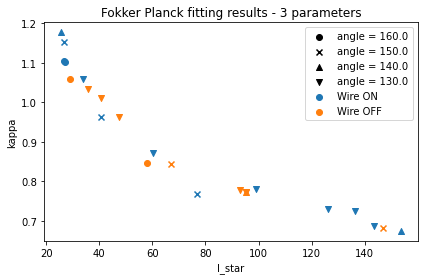

In [175]:
plt.figure()

markers = {
    160.0: "o",
    150.0: "x",
    140.0: "^",
    130.0: "v",
}

# create legend handles
for angle in markers.keys():
    plt.scatter([], [], color="black", label=f"angle = {angle}", marker=markers[angle])

plt.scatter([], [], color="C0", label="Wire ON")
plt.scatter([], [], color="C1", label="Wire OFF")

for d, f in zip(loss_list_b2, fit_results):
    plt.scatter([f.params['I_star'].value], [f.params['k'].value], c="C0" if d.wire else "C1", marker=markers[d.angle])

plt.legend()

plt.xlabel("I_star")
plt.ylabel("kappa")
plt.title("Fokker Planck fitting results - 3 parameters")

plt.tight_layout()

plt.savefig("img/fokker_planck_b2.jpg", dpi=300)


In [128]:
%matplotlib inline

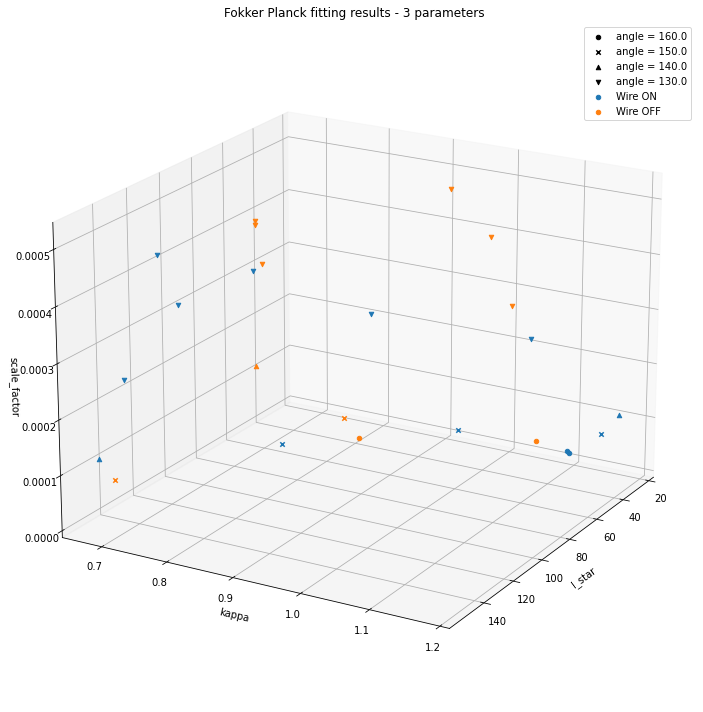

In [176]:
# make 3d plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

markers = {
    160.0: "o",
    150.0: "x",
    140.0: "^",
    130.0: "v",
}

for d, f in zip(loss_list_b2, fit_results):
    ax.scatter3D([f.params['I_star'].value], [f.params['k'].value], [1/f.params['scale_factor'].value], c="C0" if d.wire else "C1", marker=markers[d.angle])

# create legend handles
for angle in markers.keys():
    ax.scatter3D([], [], [], color="black", label=f"angle = {angle}", marker=markers[angle])

ax.scatter3D([], [], [], color="C0", label="Wire ON")
ax.scatter3D([], [], [], color="C1", label="Wire OFF")

ax.set_xlabel("I_star")
ax.set_ylabel("kappa")
ax.set_zlabel("scale_factor")

# rotate view to see the plot
ax.view_init(elev=20, azim=30)

plt.legend()
plt.title("Fokker Planck fitting results - 3 parameters")
plt.tight_layout()

plt.savefig("img/fokker_planck_b2_3D.jpg", dpi=300)



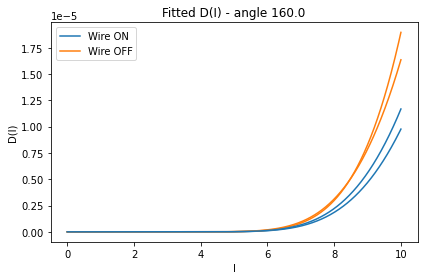

In [177]:
plt.figure()

I_test = np.linspace(0, 10, 1000)

for d, f in zip(loss_list_b2, fit_results):
    if d.angle == 160.0:
        plt.plot(
            I_test,
            nt.D(I_test, f.params['I_star'].value, f.params['k'].value, nt.standard_c(0.0, 10, f.params['I_star'].value, f.params['k'].value), True) / f.params['scale_factor'].value,
            c="C0" if d.wire else "C1",
        )

plt.plot([], [], "C0", label="Wire ON")
plt.plot([], [], "C1", label="Wire OFF")
plt.legend()

plt.xlabel("I")
plt.ylabel("D(I)")

plt.title("Fitted D(I) - angle 160.0")

plt.tight_layout()
plt.savefig("img/fokker_planck_b2_D_160.jpg", dpi=300)

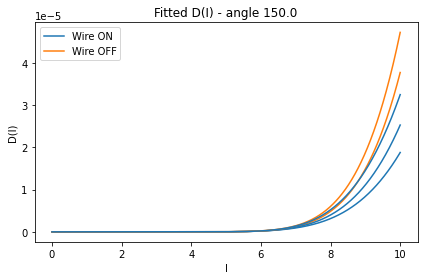

In [178]:
plt.figure()

I_test = np.linspace(0, 10, 1000)

for d, f in zip(loss_list_b2, fit_results):
    if d.angle == 150.0:
        plt.plot(
            I_test,
            nt.D(I_test, f.params['I_star'].value, f.params['k'].value, nt.standard_c(0.0, 10, f.params['I_star'].value, f.params['k'].value), True) / f.params['scale_factor'].value,
            c="C0" if d.wire else "C1",
        )

plt.plot([], [], "C0", label="Wire ON")
plt.plot([], [], "C1", label="Wire OFF")
plt.legend()

plt.xlabel("I")
plt.ylabel("D(I)")

plt.title("Fitted D(I) - angle 150.0")

plt.tight_layout()
plt.savefig("img/fokker_planck_b2_D_150.jpg", dpi=300)

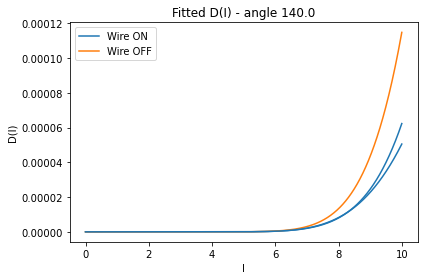

In [179]:
plt.figure()

I_test = np.linspace(0, 10, 1000)

for d, f in zip(loss_list_b2, fit_results):
    if d.angle == 140.0:
        plt.plot(
            I_test,
            nt.D(I_test, f.params['I_star'].value, f.params['k'].value, nt.standard_c(0.0, 10, f.params['I_star'].value, f.params['k'].value), True) / f.params['scale_factor'].value,
            c="C0" if d.wire else "C1",
        )

plt.plot([], [], "C0", label="Wire ON")
plt.plot([], [], "C1", label="Wire OFF")
plt.legend()

plt.xlabel("I")
plt.ylabel("D(I)")

plt.title("Fitted D(I) - angle 140.0")

plt.tight_layout()
plt.savefig("img/fokker_planck_b2_D_140.jpg", dpi=300)

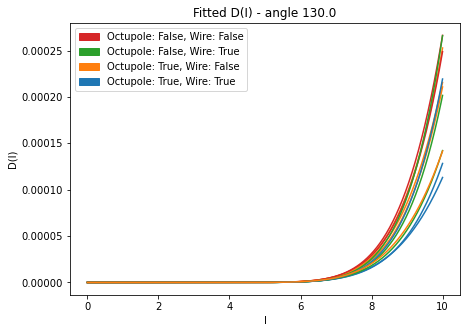

In [180]:
plt.figure(figsize=(7, 5))

I_test = np.linspace(0, 10, 1000)

colors = {
    (False, False): "C3",
    (False, True): "C2",
    (True, False): "C1",
    (True, True): "C0",
}

# make a legend entry for each color
legend_entries = []
for key, c in colors.items():
    legend_entries.append(mpatches.Patch(color=c, label="Octupole: {}, Wire: {}".format(key[0], key[1])))


for d, f in zip(loss_list_b2, fit_results):
    if d.angle == 130.0:
        plt.plot(
            I_test,
            nt.D(I_test, f.params['I_star'].value, f.params['k'].value, nt.standard_c(0.0, 10, f.params['I_star'].value, f.params['k'].value), True) / f.params['scale_factor'].value,
            c=colors[(d.octupole, d.wire)],
        )

plt.legend(handles=legend_entries)
plt.xlabel("I")
plt.ylabel("D(I)")

plt.title("Fitted D(I) - angle 130.0")

plt.savefig("img/fokker_planck_b2_D_130.jpg", dpi=300)

In [116]:
samples = 3000
I_max = 7.1

In [117]:
workers = os.cpu_count()
Ns = 10

min_I_star = 20.0
max_I_star = 150.0

_, d_I_star = np.linspace(min_I_star, max_I_star, Ns, retstep=True)

min_k = 0.3
max_k = 1.2

_, d_k = np.linspace(min_k, max_k, Ns, retstep=True)

In [118]:
def zerofy_near_border(I0: np.ndarray, border_width: int = 10) -> np.ndarray:
    """
    Zerofy the values near the border the array following a linear law.
    """
    coeff = np.linspace(1, 0, border_width)
    I0[-border_width:] = coeff * I0[-border_width:]
    return I0

I_0 = np.exp(-np.linspace(I_min, I_max, samples))
I_0 = zerofy_near_border(I_0, 100)

202
202
[25192353.42     25200056.245    25203587.163755 25210727.738755
 25222310.1      25233543.843755 25244653.915    25255966.373755
 25267177.638755 25278332.69     25289712.63     25301036.345
 25312191.373755 25323323.923755 25334377.758755 25345791.445
 25357070.18     25368326.425    25379548.923755 25390895.14
 25402151.373755 25413407.63     25424765.08     25435897.63
 25447356.273755 25459141.045    25469520.18     25473478.42
 25481181.245    25484700.93     25492055.16     25503356.373755
 25514725.08     25525835.14     25537203.823755 25548583.775
 25559648.843755 25570927.59     25582127.61     25593372.61
 25604707.558755 25615637.71     25627141.345    25638318.875
 25649856.245    25660741.393755 25672042.63     25683624.98
 25694723.795    25705788.875    25717011.373755 25728155.18
 25739535.108755 25750926.293755 25762171.293755 25773360.08
 25784458.895    25795613.923755 25806881.425    25818227.63
 25822073.42     25829315.188755 25833318.42     25840740.108

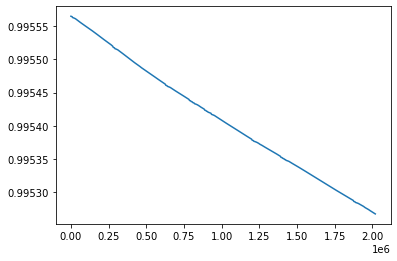

In [119]:
t = timestapms_for_b1[3]

x_data = t_b1_all[
    np.logical_and(t_b1_all >= t[0], t_b1_all <= t[1])
]
y_data = norm_loss_b1_all[
    np.logical_and(t_b1_all >= t[0], t_b1_all <= t[1])
]

print(len(x_data))
print(len(y_data))
print(x_data)
print(y_data)
plt.plot(x_data-x_data[0], y_data)

In [128]:
fit_results_b1 = []
I_list_b1 = [I_0]

for i, t in tqdm(enumerate(timestapms_for_b1), total=len(timestapms_for_b1)):
    print("i:", i)
    
    x_data = t_b1_all[
        np.logical_and(t_b1_all >= t[0], t_b1_all <= t[1])
    ]
    x_data -= x_data[0]
    y_data = norm_loss_b1_all[
        np.logical_and(t_b1_all >= t[0], t_b1_all <= t[1])
    ]
    print(y_data[0], y_data[-1])

    params = lmfit.Parameters()
    params.add('I_max', value=I_max, vary=False)
    params.add('starting_point', value=y_data[0], vary=False)
    params.add('ending_point', value=y_data[-1], vary=False)
    params.add('dt', value=-1, vary=False)
    params.add('scale_factor', value=-1, vary=False)
    params.add('n_iterations', value=-1, vary=False)
    params.add('I_star', value=50.0, min=min_I_star, max=max_I_star)
    params.add('k', value=0.9, min=min_k, max=max_k)
    
    result = lmfit.minimize(resid_lmfit, params, args=(x_data, y_data, I_0), method="brute", workers=20, Ns=20)
    
    print("Brute result:")
    print("I_star:", result.params['I_star'].value)
    print("k:", result.params['k'].value)
    print("scale_factor:", result.params['scale_factor'].value)

    print("Refining:")
    new_min_I_star = result.params['I_star'].value - d_I_star
    new_max_I_star = result.params['I_star'].value + d_I_star
    new_min_k = result.params['k'].value - d_k
    new_max_k = result.params['k'].value + d_k

    params = lmfit.Parameters()
    params.add('I_max', value=I_max, vary=False)
    params.add('starting_point', value=y_data[0], vary=False)
    params.add('ending_point', value=y_data[-1], vary=False)
    params.add('dt', value=-1, vary=False)
    params.add('scale_factor', value=-1, vary=False)
    params.add('n_iterations', value=-1, vary=False)
    params.add('I_star', value=result.params['I_star'].value, min=new_min_I_star, max=new_max_I_star)
    params.add('k', value=result.params['k'].value, min=new_min_k, max=new_max_k)

    result = lmfit.minimize(resid_lmfit, params, args=(x_data, y_data, I_0))
    fit_results_b1.append(result)

    print("Refined result:")
    print("I_star:", result.params['I_star'].value)
    print("k:", result.params['k'].value)
    print("scale_factor:", result.params['scale_factor'].value)

    vals, data0, data1, _ = full_iteration(
        result.params['I_star'].value,
        result.params['k'].value,
        result.params['I_max'].value,
        I_0,
        result.params['dt'].value,
        n_steps=10000)

    I_0 = data1[1]
    I_list_b1.append(I_0)

  0%|          | 0/24 [00:00<?, ?it/s]

i: 0
0.9989134457712271 0.9973220554904157


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halve

Reached maximum iterations
Just keeping it for speed...


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


Brute result:
I_star: 20.0
k: 1.1526315789473682
scale_factor: 4177568.0968775004
Refining:
Refined result:
I_star: 19.12573378987535
k: 1.1959940356486556
scale_factor: 4177568.0968775004
i: 1
0.9969879581595925 0.996170358606417


KeyboardInterrupt: 

In [124]:
y_data

array([0.99698796, 0.99698628, 0.99698467, 0.99698307, 0.9969814 ,
       0.99697969, 0.99697808, 0.99697629, 0.99697462, 0.996973  ,
       0.99697142, 0.99696986, 0.99696832, 0.9969678 , 0.99696676,
       0.99696624, 0.99696516, 0.99696354, 0.99696175, 0.99696023,
       0.99695858, 0.99695699, 0.9969554 , 0.99695383, 0.99695228,
       0.99695073, 0.99694925, 0.99694777, 0.99694626, 0.99694468,
       0.99694308, 0.99694154, 0.99693994, 0.99693834, 0.9969367 ,
       0.99693512, 0.9969336 , 0.99693205, 0.99693046, 0.99692879,
       0.99692713, 0.99692555, 0.99692394, 0.99692233, 0.9969207 ,
       0.99691909, 0.99691744, 0.99691571, 0.99691407, 0.99691239,
       0.99691072, 0.99690905, 0.99690745, 0.99690583, 0.99690424,
       0.99690249, 0.99690106, 0.9968994 , 0.99689777, 0.99689594,
       0.99689431, 0.99689272, 0.9968911 , 0.99688944, 0.99688779,
       0.99688609, 0.99688444, 0.99688282, 0.99688115, 0.99687952,
       0.99687796, 0.99687634, 0.99687473, 0.99687309, 0.99687

0.996989331886507 0.9969879581595925
0.9961703214802187 0.996170358606417


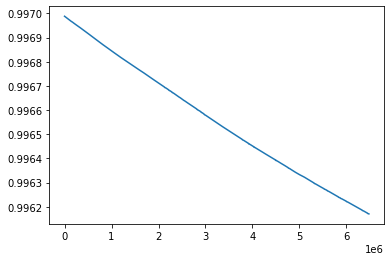

In [125]:
plt.plot(x_data, y_data)
print(b1_full_interp(t[0]), y_data[0])
print(b1_full_interp(t[1]), y_data[-1])

In [ ]:
with open("fit_results_b1_cuts.pkl", "wb") as f:
    pickle.dump((fit_results, I_list), f)

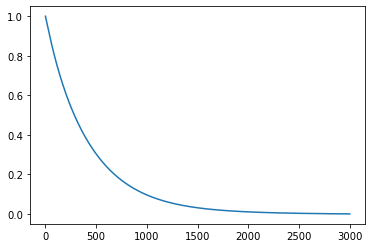

In [111]:
plt.plot(I_list_b1[-1])